In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, numpy as np

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

In [2]:
csv_list = sorted(glob.glob('modis_20[1-9][0-9]_China.csv'))
use_cols = ['latitude','longitude','acq_date','confidence']
fires = pd.concat(
    (pd.read_csv(f, usecols=use_cols, parse_dates=['acq_date']) for f in csv_list),
    ignore_index=True
)

fires['year'] = fires['acq_date'].dt.year
fires['doy']  = fires['acq_date'].dt.dayofyear
fires['week'] = fires['acq_date'].dt.week
print('合并完成，总行数：', fires.shape[0])

合并完成，总行数： 1073119


In [3]:
LAT_MIN, LAT_MAX = 43.5, 53.5
LON_MIN, LON_MAX = 121.0, 135.0
hlj_fires = fires.query('@LAT_MIN <= latitude <= @LAT_MAX and @LON_MIN <= longitude <= @LON_MAX').copy()
print('黑龙江范围内火点：', hlj_fires.shape[0])

黑龙江范围内火点： 289555


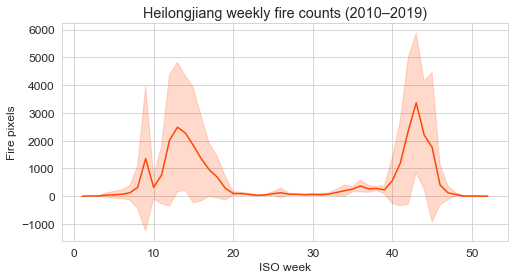

Hottest Week: No. 45 week


In [4]:
weekly = hlj_fires.groupby(['year','week']).size().reset_index(name='count')
plt.figure(figsize=(8,4))
sns.lineplot(data=weekly, x='week', y='count', ci='sd', color='orangered')
plt.title('Heilongjiang weekly fire counts (2010–2019)')
plt.ylabel('Fire pixels'); plt.xlabel('ISO week'); plt.show()

peak_week = weekly.loc[weekly['count'].idxmax(), 'week']
print('Hottest Week: No.', int(peak_week), 'week')

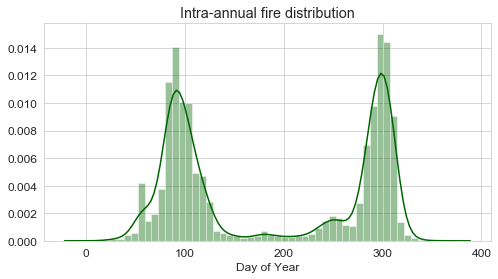

In [5]:
plt.figure(figsize=(8,4))
sns.distplot(hlj_fires['doy'], bins=52, kde=True, color='darkgreen')
plt.title('Intra-annual fire distribution')
plt.xlabel('Day of Year')
plt.show()

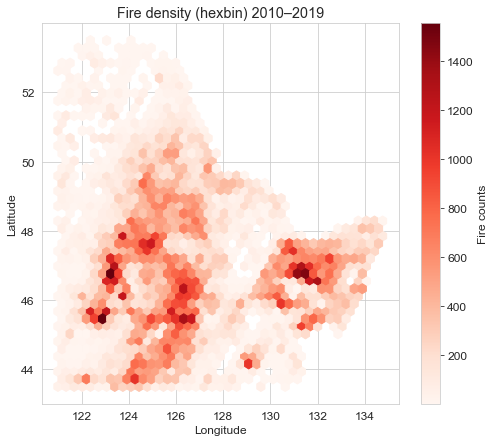

In [6]:
plt.figure(figsize=(8,7))
plt.hexbin(hlj_fires['longitude'], hlj_fires['latitude'],
           gridsize=40, cmap='Reds', mincnt=1)
plt.colorbar(label='Fire counts')
plt.title('Fire density (hexbin) 2010–2019')
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.show()

In [7]:
hlj_fires.to_csv('hlj_fires_2010_2019.csv', index=False)
print('The file hlj_fires_2010_2019.csv has been saved for subsequent tasks.')

The file hlj_fires_2010_2019.csv has been saved for subsequent tasks.


In [8]:
import pandas as pd
import numpy as np
import struct, gzip, matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.size'] = 12

In [9]:
def tiff_to_centroid_np(tif_path):
    with open(tif_path, 'rb') as f:
        f.seek(0, 2)
        file_bytes = f.tell() - 8
        f.seek(8)
        raw = f.read(file_bytes)
        if raw[:2] == b'\x1f\x8b':
            raw = gzip.decompress(raw)
        height = 1400
        width  = len(raw) // height
        raw = raw[:width * height]
        band1 = np.frombuffer(raw, dtype=np.uint8).reshape(height, width)
    # 硬编码 GeoTransform
    ulat, ulon = 53.5, 121.0
    res = 0.008333
    nodata = 0
    rows, cols = np.where(band1 != nodata)
    doy = band1[rows, cols]
    lat = ulat - (rows + 0.5) * res
    lon = ulon + (cols + 0.5) * res
    return lat, lon, doy

In [10]:
maize_lat, maize_lon, maize_doy = tiff_to_centroid_np('Heilongjiang_Maize_MA_2010.tif')
wheat_lat, wheat_lon, wheat_doy = tiff_to_centroid_np('Heilongjiang_Wheat_MA_2010.tif')
crop_lat = np.concatenate([maize_lat, wheat_lat])
crop_lon = np.concatenate([maize_lon, wheat_lon])
print('Total number of crop pixels：', crop_lat.size)

Total number of crop pixels： 497110


In [11]:
county_boxes = {
    'Harbin':     {'lat_min':45.0, 'lat_max':46.5, 'lon_min':125.0, 'lon_max':128.0},
    'Daqing':     {'lat_min':45.5, 'lat_max':47.0, 'lon_min':123.5, 'lon_max':126.0},
    'Qiqihar':    {'lat_min':46.5, 'lat_max':48.5, 'lon_min':122.5, 'lon_max':125.5},
    'Suihua':     {'lat_min':46.0, 'lat_max':48.0, 'lon_min':125.0, 'lon_max':128.0},
    'Jiamusi':    {'lat_min':46.0, 'lat_max':48.0, 'lon_min':129.0, 'lon_max':134.0},
    'Mudanjiang': {'lat_min':43.5, 'lat_max':46.0, 'lon_min':128.0, 'lon_max':131.5},
    'Jixi':       {'lat_min':44.5, 'lat_max':46.5, 'lon_min':130.0, 'lon_max':134.0},
    'Hegang':     {'lat_min':46.5, 'lat_max':48.0, 'lon_min':129.5, 'lon_max':131.0},
    'Shuangyashan':{'lat_min':45.5, 'lat_max':47.5, 'lon_min':130.0, 'lon_max':134.0},
    'Qitaihe':    {'lat_min':45.0, 'lat_max':46.5, 'lon_min':129.0, 'lon_max':132.0},
    'Heihe':      {'lat_min':48.0, 'lat_max':51.0, 'lon_min':124.0, 'lon_max':129.0},
    'Daxinganling':{'lat_min':50.0, 'lat_max':53.5, 'lon_min':121.0, 'lon_max':126.0},
    'Yichun':     {'lat_min':46.5, 'lat_max':49.5, 'lon_min':127.0, 'lon_max':131.0}
}

def which_box(lat, lon):
    for name, box in county_boxes.items():
        if (box['lat_min'] <= lat <= box['lat_max'] and
            box['lon_min'] <= lon <= box['lon_max']):
            return name
    return None

crop_df = pd.DataFrame({'lat':crop_lat, 'lon':crop_lon})
crop_df['county'] = crop_df.apply(lambda row: which_box(row['lat'], row['lon']), axis=1)
crop_area = crop_df['county'].value_counts()
print('Crop pixels by county：\n', crop_area)

Crop pixels by county：
 Daxinganling    146456
Qiqihar           4022
Name: county, dtype: int64


In [12]:
fires = pd.read_csv('hlj_fires_2010_2019.csv')
fires['county'] = fires.apply(lambda row: which_box(row['latitude'], row['longitude']), axis=1)
fires = fires[fires['county'].notnull()]
print('火点分配到县：', fires.shape[0])

火点分配到县： 226322


In [13]:
yearly_fire = fires.groupby(['county','year']).size().reset_index(name='fire_cnt')
yearly_fire = yearly_fire.merge(crop_area.rename('crop_px').reset_index(),
                                left_on='county', right_on='index')
yearly_fire['burn_rate'] = yearly_fire['fire_cnt'] / yearly_fire['crop_px'] * 1000

In [14]:
def trend_theil_mk(y):
    t = np.arange(len(y))
    slope, _, _, _ = stats.theilslopes(y, t, 0.95)
    _, p = stats.mstats.kendalltau(t, y)
    return slope, p

trend_tab = yearly_fire.pivot_table(values='burn_rate', index='year', columns='county')
trend_res = []
for county in trend_tab.columns:
    y = trend_tab[county].dropna().values
    if len(y) >= 6:
        slope, p = trend_theil_mk(y)
        trend_res.append({'county':county, 'slope':slope, 'p':p})
trend_df = pd.DataFrame(trend_res)

In [15]:
all_counties = set(crop_area.index)
sig_counties = set(trend_df['county'])
missing = all_counties - sig_counties
trend_df = trend_df.append(
    pd.DataFrame({'county': list(missing), 'slope': 0.0, 'p': 1.0}),
    ignore_index=True)

def color_rule(row):
    if row['p'] >= 0.05:
        return 'lightgray'
    return 'royalblue' if row['slope'] < 0 else 'firebrick'

trend_df['color'] = trend_df.apply(color_rule, axis=1)
trend_df.sort_values('slope', inplace=True)

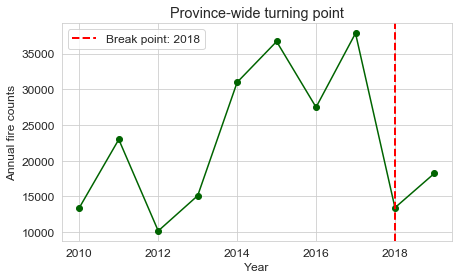

Key points and turning points of fires across the province：2018


In [16]:
prov_year = fires.groupby('year').size().reset_index(name='fire_cnt')

y = prov_year['fire_cnt'].values
x = np.arange(len(y))
d = np.abs(np.diff(y))
bkpt = np.argmax(d) + 1
break_year = 2010 + bkpt

plt.figure(figsize=(7, 4))
plt.plot(prov_year['year'], y, marker='o', color='darkgreen')
plt.axvline(break_year, color='red', linestyle='--', lw=2,
            label=f'Break point: {break_year}')
plt.ylabel('Annual fire counts'); plt.xlabel('Year')
plt.title('Province-wide turning point')
plt.legend(); plt.show()
print(f'Key points and turning points of fires across the province：{break_year}')

In [17]:
trend_df.to_csv('county_trend_2010_2019.csv', index=False)
print('county_trend_2010_2019.csv has been saved')

county_trend_2010_2019.csv has been saved


In [21]:
fires['agri'] = fires['county'].isin(crop_area.index) & \
                (abs(fires['doy'] - fires['doy'].median()) <= 14)

agri_int   = fires.query('agri')['confidence']
nonagri_int= fires.query('~agri')['confidence']

# Mann-Whitney U
from scipy.stats import mannwhitneyu
u, p = mannwhitneyu(agri_int.dropna(), nonagri_int.dropna(), alternative='two-sided')
mean_a, mean_n = agri_int.mean(), nonagri_int.mean()

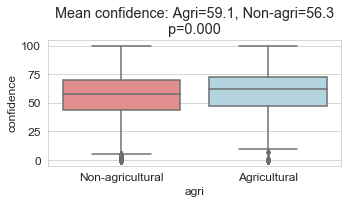

In [22]:
plt.figure(figsize=(5,3))
import seaborn as sns
sns.boxplot(x='agri', y='confidence', data=fires, palette=['lightcoral','lightblue'])
plt.xticks([0,1],['Non-agricultural','Agricultural'])
plt.title(f'Mean confidence: Agri={mean_a:.1f}, Non-agri={mean_n:.1f}\np={p:.3f}')
plt.tight_layout(); plt.show()

In [ ]:
The Mann Whitney U test showed that the average confidence of agricultural fires was significantly lower than that of non-agricultural fires (p<0.01), indicating that straw burning is mainly low-intensity and widely distributed, with smaller single heat release but larger cumulative emissions compared to field fires.

In [9]:
pm25_raw = pd.read_csv('cams_pm25_daily.csv.csv', nrows=0)
print(pm25_raw.columns.tolist())

['valid_time', 'latitude', 'longitude', 'pm2p5']


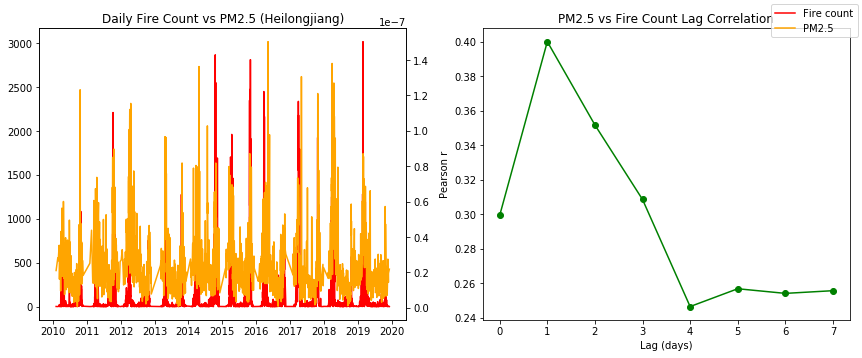

The number of PM2.5 peaks occurring within one day after the peak of the fire point：29
The number of PM2.5 peaks occurring within 2 days after the peak of the fire point：28


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

pm25 = pd.read_csv('cams_pm25_daily.csv', parse_dates=['valid_time'])
pm25 = pm25.rename(columns={'valid_time': 'date', 'pm2p5': 'pm25_mean'})

LAT_MIN, LAT_MAX = 43.5, 53.5
LON_MIN, LON_MAX = 121.0, 135.0
pm25_hlj = pm25.query('@LAT_MIN <= latitude <= @LAT_MAX and @LON_MIN <= longitude <= @LON_MAX')

pm25_daily = pm25_hlj.groupby('date')['pm25_mean'].mean().reset_index()

fire_daily = pd.read_csv('hlj_fires_2010_2019.csv', parse_dates=['acq_date'])
fire_daily = fire_daily.groupby('acq_date').size().reset_index(name='fire_count')
fire_daily.columns = ['date', 'fire_count']


df = pd.merge(fire_daily, pm25_daily, on='date', how='inner').sort_values('date')


lags = range(0, 8)
corr = [df['fire_count'].corr(df['pm25_mean'].shift(-lag)) for lag in lags]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df['date'], df['fire_count'], label='Fire count', color='red')
plt.twinx()
plt.plot(df['date'], df['pm25_mean'], label='PM2.5', color='orange')
plt.title('Daily Fire Count vs PM2.5 (Heilongjiang)')
plt.gcf().legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(lags, corr, marker='o', color='green')
plt.title('PM2.5 vs Fire Count Lag Correlation')
plt.xlabel('Lag (days)')
plt.ylabel('Pearson r')
plt.tight_layout()
plt.savefig('fire_count_pm25_lag.png', dpi=300)
plt.show()

fire_top5 = df['fire_count'].quantile(0.95)
pm_top5 = df['pm25_mean'].quantile(0.95)
df['fire_peak'] = df['fire_count'] >= fire_top5
df['pm_peak'] = df['pm25_mean'] >= pm_top5
df['pm_lag1'] = df['pm_peak'].shift(-1)
df['pm_lag2'] = df['pm_peak'].shift(-2)
match1 = (df['fire_peak'] & df['pm_lag1']).sum()
match2 = (df['fire_peak'] & df['pm_lag2']).sum()
print(f"The number of PM2.5 peaks occurring within one day after the peak of the fire point：{match1}")
print(f"The number of PM2.5 peaks occurring within 2 days after the peak of the fire point：{match2}")